In [1]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
import math
import random
from scipy.signal import detrend, butter, lfilter
from scipy.signal.windows import tukey
from scipy.fft import fftfreq, fft
import joblib

plt.style.use('bmh')
mpl.rcParams['font.size'] = 12
mpl.rcParams['axes.linewidth'] = 1
image_path = '.\images_new'
colors = plt.rcParams['axes.prop_cycle'].by_key()['color'] 

Import data

In [2]:
# get the number of files located in the data folder
dir_path = r'./data/raw_data/single'
source_file_nr = len([entry for entry in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, entry))])

for number in range(source_file_nr):
        with open(f'./data/raw_data/single/single_source_scenario_{number + 1}.data', 'rb') as pickle_file:
                data = pickle.load(pickle_file)
                df_sorted = data[0]
                signals_single = data[1]
                df_plotting_single = df_sorted[['flattened_index', 'power_dbm', 'phase_absolute']].copy()
                df_plotting_single['cluster'] = np.full(len(signals_single), (number+1)) # Cluster labels should begin from 1

        if number == 0:
                signals = signals_single
                df_plotting = df_plotting_single.copy()
        else: 
                signals = np.concatenate((signals, signals_single))
                df_plotting = pd.concat((df_plotting, df_plotting_single))


## Plotting for paper

### PRPD plot

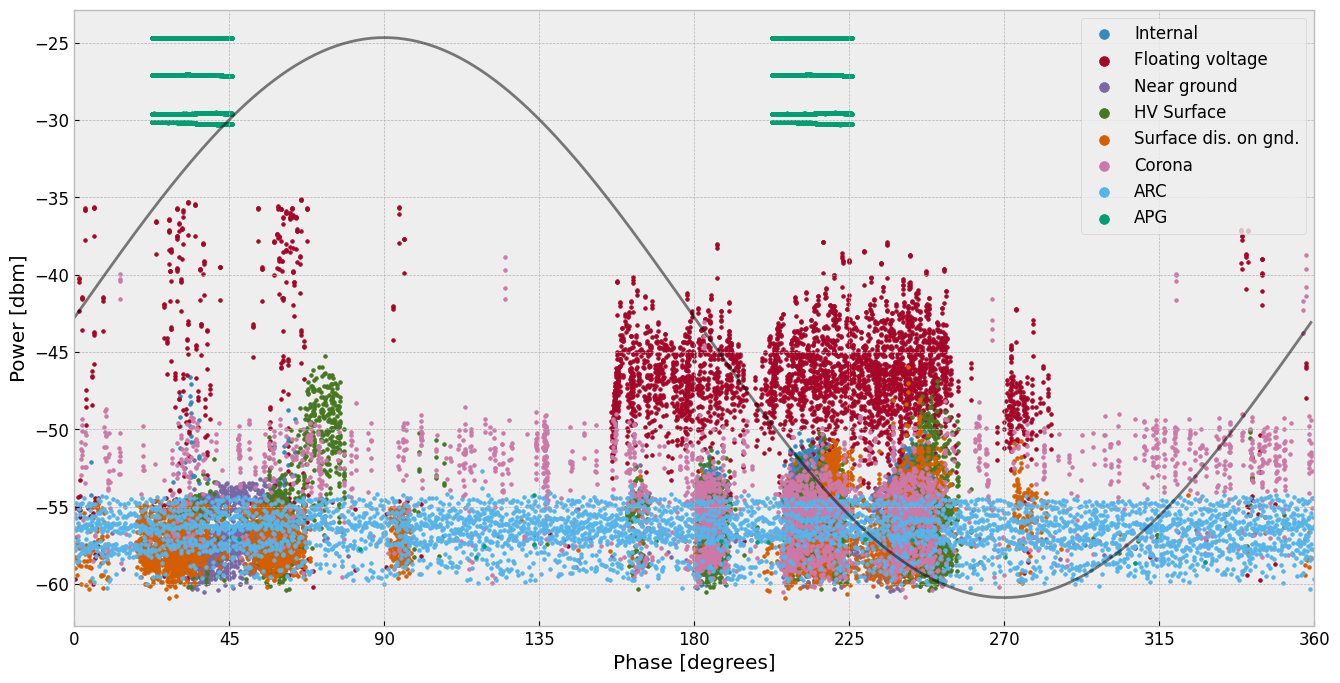

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [3]:
power = df_plotting.power_dbm
phase = df_plotting.phase_absolute
cluster = df_plotting.cluster
labels_pulses = ['Internal', 'Floating voltage', 'Near ground', 'HV Surface', 'Surface dis. on gnd.', 'Corona', 'ARC', 'APG']


# Consider a phase range of 360 degrees
degrees = np.arange(360)
# Define a sine wave representing the power cycle
power_range = (max(power) - min(power)) / 2
power_mid = (max(power) + min(power)) / 2
power_cycle = np.array([power_range * np.sin(math.radians(deg)) + power_mid for deg in degrees])

    
fig, ax = plt.subplots(figsize = (16, 8))
ax.plot(power_cycle, c='k', alpha=0.5)
for i, c in enumerate(np.unique(cluster)):
    ax.scatter(phase[cluster == c], power[cluster == c], label=labels_pulses[i], s=7)
ax.set_ylabel('Power [dbm]')
ax.set_xlabel('Phase [degrees]')
lgnd  = ax.legend()
for i, c in enumerate(np.unique(cluster)):
    lgnd.legend_handles[i]._sizes = [50]

ax.set_xlim(0, 360)
ax.set_xticks(np.arange(0, 361, 45))
plt.show()
fig.tight_layout()
fig.savefig(os.path.join(image_path, 'PRPD.eps'), format='eps')

### Time and freq plots

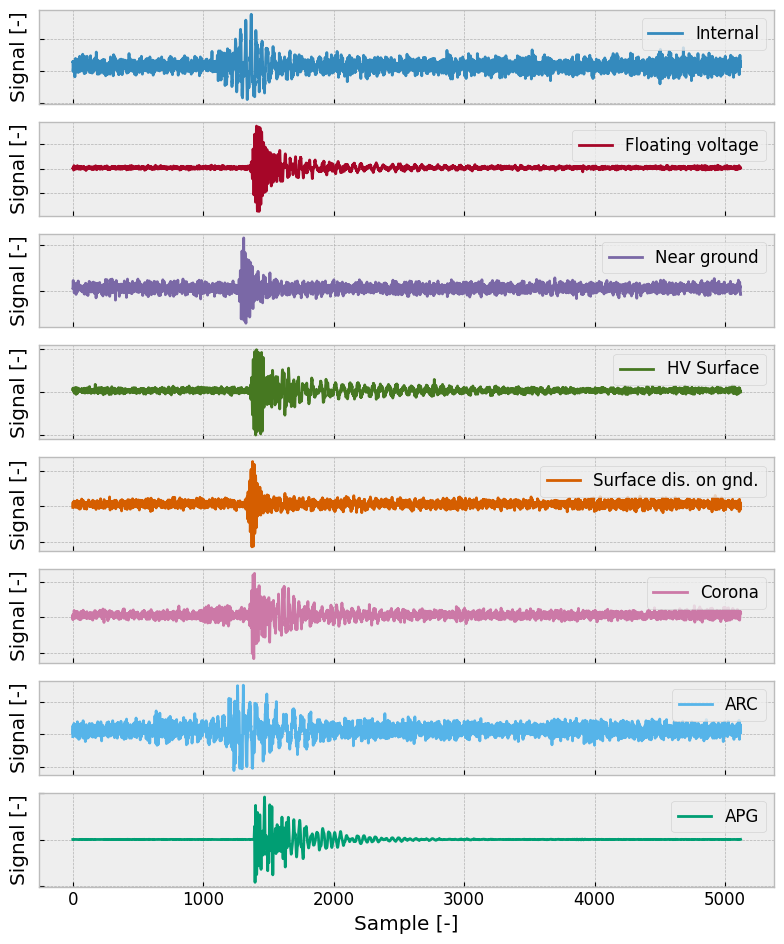

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [4]:
# Find the number of clusters to identify
unique_clusters = np.unique(cluster)
# Define the plot
fig, axs = plt.subplots(len(unique_clusters), sharex='all', figsize = (8, 1.2*len(unique_clusters)))
# Plot random member of each class
for c, ax in zip(np.sort(unique_clusters), axs.ravel()):
    signals_cluster = signals[cluster == c]
    id_cluster = random.randint(0, len(signals_cluster))
    ax.plot(signals_cluster[0], label=labels_pulses[c-1], c = colors[c-1])
    ax.legend(loc="upper right")
    
    ax.set_yticklabels([])
    ax.set_ylabel('Signal [-]')
ax.set_xlabel('Sample [-]')
# ax.set_xlim(1000, 2500)
# ax.set_xticks(np.arange(1000, 2501, 500))
fig.tight_layout()
plt.show()
fig.savefig(os.path.join(image_path, 'time_domain.eps'), format='eps')

In [5]:
def butter_bandpass(cut, fs, order=5):
    return butter(order, cut, fs=fs, btype='lowpass')

def butter_bandpass_filter(data, cut, fs, order=5):
    b, a = butter_bandpass(cut, fs, order=order)
    y = lfilter(b, a, data)
    return y

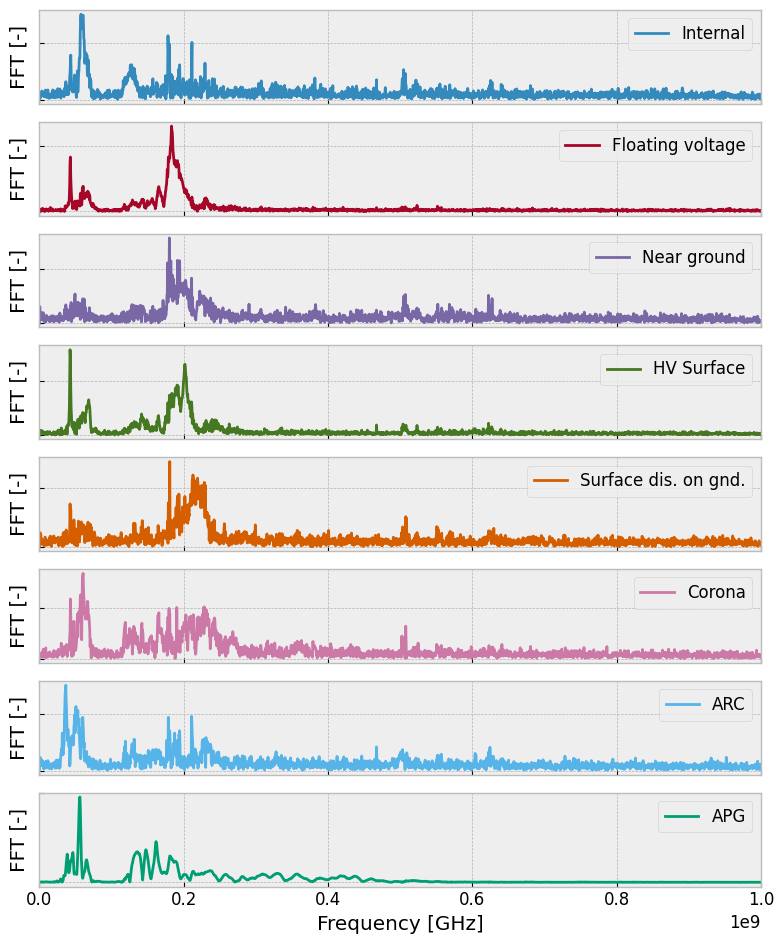

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [6]:
# Find the number of clusters to identify
unique_clusters = np.unique(cluster)
# Define the plot
fig, axs = plt.subplots(len(unique_clusters), sharex='all', figsize = (8, 1.2*len(unique_clusters)))
# Plot random member of each class
for c, ax in zip(np.sort(unique_clusters), axs.ravel()):
    signals_cluster = signals[cluster == c]
    id_cluster = random.randint(0, len(signals_cluster))
    chosen_signal = signals_cluster[0]
    chosen_signal = detrend(chosen_signal)
    chosen_signal = butter_bandpass_filter(chosen_signal, 1E9, 2.5E9)
    
    N = len(chosen_signal)
    # sample spacing
    T = 1.0 / 2.5E9
    x = np.linspace(0.0, N*T, N, endpoint=False)

    x_fft = fftfreq(N, T)[:N//2]
    y_fft = fft(chosen_signal)

    # ax.plot(chosen_signal, label=labels_pulses[c-1], c = colors[c-1])
    ax.plot(x_fft, np.abs(y_fft[0:N//2]), label=labels_pulses[c-1], c = colors[c-1])
    ax.legend(loc="upper right")
    
    ax.set_yticklabels([])
    ax.set_ylabel('FFT [-]')
ax.set_xlabel('Frequency [GHz]')
ax.set_xlim(0, 1E9)
# ax.set_xticks(np.arange(1000, 3001, 500))
plt.tight_layout()
plt.show()
fig.savefig(os.path.join(image_path, 'freq_domain.eps'), format='eps')

### Results plots

In [ ]:
labels = ['SVC', 'RFC', 'KNN', 'GBC', 'ANN']
colors_1 = ['#348ABD', '#A60628', '#7A68A6', '#467821', '#D55E00']
colors_2 = ['#1e4e6b', '#570315', '#4d4269', '#243d11', '#853b01']
xtick_labels = ['Scenario I', 'Scenario II', 'Scenario III']

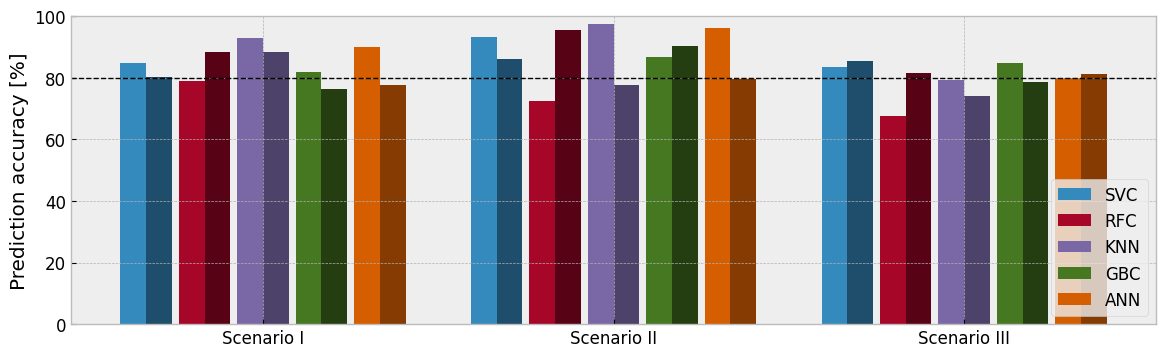

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<Figure size 640x480 with 0 Axes>

In [7]:
class_results_bin = np.array([[84.83,	93.26,	83.44],
                            [79.03,	72.39,	67.52],
                            [92.79,	97.51,	79.34],
                            [81.93,	86.80,	84.71],
                            [89.98,	96.12,	79.89]])

class_results_multi= np.array([[80.15,	86.15,	85.44],
                                [88.48,	95.38,	81.53],
                                [88.39,	77.75,	74.16],
                                [76.50,	90.40,	78.62],
                                [77.72,	79.69,	81.16]])


fig = plt.figure(figsize=(14, 4))
width = 0.2
x = np.arange(3)
for scen in range(3):
    for clf in range(5):
        if scen == 0:
            plt.bar(scen*6+(clf-0.22), height=class_results_bin[clf, scen], width=0.44, color = colors_1[clf], label = labels[clf])
        else:
            plt.bar(scen*6+(clf-0.22), height=class_results_bin[clf, scen], width=0.44, color = colors_1[clf])
        plt.bar(scen*6+(clf+0.22), height=class_results_multi[clf, scen], width=0.44, color = colors_2[clf])

plt.axhline(y=80, linestyle='--', c='k', linewidth = 1)
plt.xticks(np.array([0, 6, 12])+2, labels=xtick_labels)
plt.legend(loc='lower right')
plt.ylabel('Prediction accuracy [%]')

plt.ylim(0, 100)
plt.show()
plt.tight_layout()
fig.savefig(os.path.join(image_path, 'Corona_as_PD.eps'), format='eps')

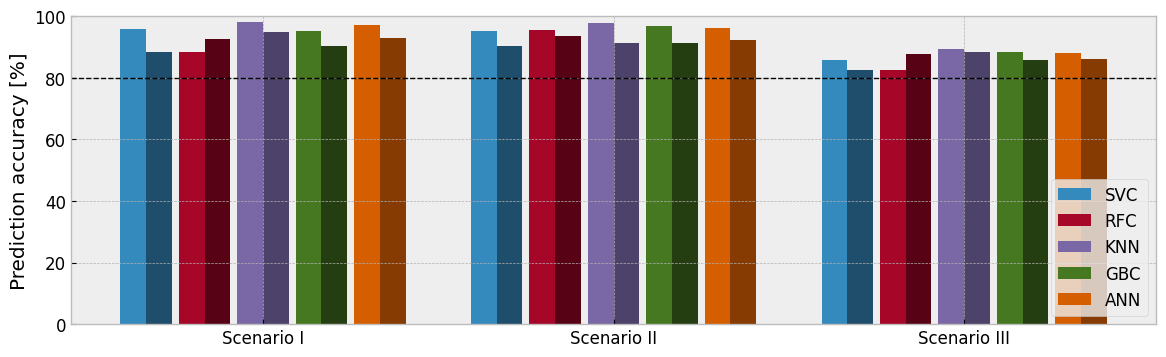

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<Figure size 640x480 with 0 Axes>

In [8]:
class_results_bin = np.array([
    [95.88,	95.20,	85.81],
    [88.39,	95.57,	82.53],
    [98.03,	97.78,	89.17],
    [95.13,	96.95,	88.44],
    [97.00,	96.21,	88.17]
])

class_results_multi= np.array([
    [88.48,	90.21,	82.62],
    [92.42,	93.63,	87.63],
    [94.76,	91.23,	88.35],
    [90.45,	91.41,	85.90],
    [93.00,	92.40,	86.00]
])

fig = plt.figure(figsize=(14, 4))
width = 0.2
x = np.arange(3)
for scen in range(3):
    for clf in range(5):
        if scen == 0:
            plt.bar(scen*6+(clf-0.22), height=class_results_bin[clf, scen], width=0.44, color = colors_1[clf], label = labels[clf])
        else:
            plt.bar(scen*6+(clf-0.22), height=class_results_bin[clf, scen], width=0.44, color = colors_1[clf])
        plt.bar(scen*6+(clf+0.22), height=class_results_multi[clf, scen], width=0.44, color = colors_2[clf])

plt.axhline(y=80, linestyle='--', c='k', linewidth = 1)
plt.xticks(np.array([0, 6, 12])+2, labels=xtick_labels)
plt.legend(loc='lower right')
plt.ylabel('Prediction accuracy [%]')

plt.ylim(0, 100)
plt.show()
plt.tight_layout()

fig.savefig(os.path.join(image_path, 'Corona_as_int.eps'), format='eps')

### Onset detection plot

In [9]:
# from onset_detection import onset_detection_fun

# signal_short, onset, ds6 = onset_detection_fun(signals_single[:2])
# signal_short = signal_short[1]
# onset = onset[1]

In [10]:
# plt.style.use('bmh')
# fig, ax = plt.subplots(2, figsize = (8, 8), sharex=True)

# ax[0].plot(signals_single[1], label = 'Original signal')
# ax[0].plot(np.arange(onset, onset+625), signal_short, label = 'Extracted signal')
# ax[0].set_ylabel('Signal strength [-]')
# ax[0].legend()

# ax[1].plot(np.arange(500, 2000, 5), ds6)
# ax[1].axhline(0.1*np.max(ds6), c='k', linestyle = '--', label = 'threshold')
# ax[1].set_ylabel('Derivative of 6th HOS')
# ax[1].set_xlabel('Signal sample [-]')

# plt.xlim(500, 2000)
# plt.legend()
# plt.show()

# fig.savefig(os.path.join(image_path, 'onset_detection.eps'), format='eps')